In [43]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans
from scipy import stats
from nltk.corpus import stopwords

In [85]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

### Read in Data

In [44]:
df = pd.read_csv("/Users/gabrieltaylor/Python/STAT542/en.openfoodfacts.org.products.tsv", sep = "\t")

/Users/gabrieltaylor/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot Missing Values

In [46]:
miss_vals = pd.DataFrame(df.isna().mean()).reset_index()
miss_vals.columns = ["Columns", "MV Rate"]
miss_vals = miss_vals.sort_values("MV Rate")

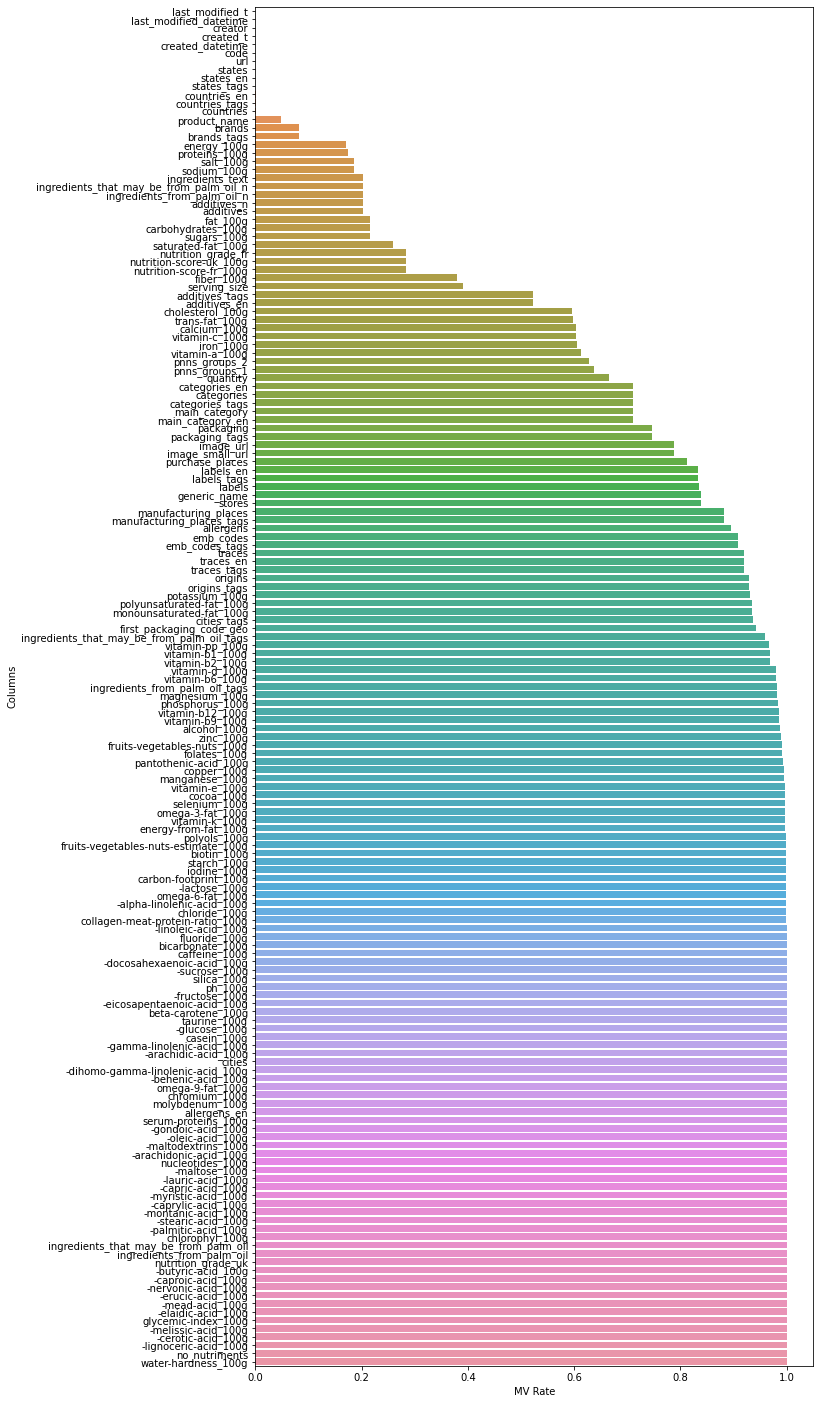

In [47]:
plt.figure(figsize = (10, 25))
sns.barplot("MV Rate", "Columns", data = miss_vals, orient = "h")

In [48]:
def scale(x):
    return (x - np.mean(x)) / np.std(x)

## Clustering Macronutrients

In [49]:
keep_cols = ['ingredients_text',
             'carbohydrates_100g',
             'fiber_100g',
             'sugars_100g',
             'proteins_100g', 
             'fat_100g', 
             'saturated-fat_100g']
clean_df = df[keep_cols]
clean_df = clean_df.dropna()

In [50]:
clean_ingre = lambda s: " ".join( map( lambda s1: s1.strip().replace(" ", "-") , s.lower().replace(".","").replace("(",",").replace(")",",").split(",") ) )

In [51]:
clean_df["ingredients_text"] = [clean_ingre(i) for i in clean_df["ingredients_text"]]

### Keep Only Rows With The Most Common Ingredients

Rows containing ingredients that are **not** in the the most common words list are dropped

In [52]:
all_words = [i for ing in clean_df['ingredients_text'] for i in ing.split()]

In [53]:
most_common_words = dict(Counter(all_words).most_common(1000))

In [54]:
clean_df = clean_df[[all(i in most_common_words.keys() for i in i_list.split()) for i_list in clean_df['ingredients_text']]]

In [55]:
clean_df.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
2,peanuts wheat-flour sugar rice-flour tapioca-s...,60.71,7.1,17.86,17.86,17.86,0.00
30,organic-coconut,53.33,6.7,6.67,6.67,30.00,26.67
38,organic-coconut,24.00,16.0,7.00,6.00,65.00,57.00
148,cranberries sugar sunflower-oil,83.33,10.0,66.67,0.00,0.00,0.00
149,apricots sulfur-dioxide,62.50,7.5,52.50,2.50,0.00,0.00


In [56]:
df.shape

(356027, 163)

In [57]:
clean_df.shape

(13091, 7)

In [58]:
(12277 - 356027) / 356027

-0.9655166602532954

### Remove outliers

In [61]:
clean_df = clean_df[(np.abs(stats.zscore(clean_df.drop(["ingredients_text"], axis = 1))) < 3).all(axis = 1)]

In [62]:
clean_df.describe()

,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
count,12277.000000,12277.000000,12277.000000,12277.000000,12277.00000,12277.000000
mean,28.127085,2.700839,11.176865,9.885555,15.22132,4.956619
std,29.103303,3.504133,18.002026,9.279081,19.13315,7.077012
min,0.000000,0.000000,-1.200000,0.000000,0.00000,0.000000
25%,3.700000,0.000000,0.000000,1.600000,0.00000,0.000000
50%,14.290000,1.600000,3.570000,7.000000,3.33000,0.340000
75%,56.250000,3.600000,10.620000,17.650000,28.57000,7.140000
max,100.000000,18.000000,73.330000,38.460000,82.14000,30.000000


### Center and Scale

In [63]:
for col in keep_cols[1:]:
    clean_df[col] = scale(np.array(clean_df[col]))

In [66]:
clean_df.describe()

,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
count,1.227700e+04,1.227700e+04,1.227700e+04,1.227700e+04,1.227700e+04,1.227700e+04
mean,1.111218e-16,-4.167067e-17,9.260148e-17,4.282818e-17,3.935563e-17,1.574225e-16
std,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00
min,-9.664962e-01,-7.707895e-01,-6.875542e-01,-1.065403e+00,-7.955794e-01,-7.004115e-01
25%,-8.393577e-01,-7.707895e-01,-6.208924e-01,-8.929648e-01,-7.955794e-01,-7.004115e-01
50%,-4.754666e-01,-3.141672e-01,-4.225733e-01,-3.109869e-01,-6.215288e-01,-6.523667e-01
75%,9.663529e-01,2.566106e-01,-3.093475e-02,8.368028e-01,6.977013e-01,3.085299e-01
max,2.469680e+00,4.366211e+00,3.452704e+00,3.079573e+00,3.497668e+00,3.538838e+00


### Summary Plots

In [73]:
plot_df = clean_df.join(df['nutrition-score-fr_100g']).dropna()

In [91]:
plot_df.columns = ['ingr', 'carbohydrates', 'fiber', 'sugars', 'proteins', 'fat', 'saturated fat', 'nutrition score']

In [88]:
plt.style.use('fivethirtyeight')

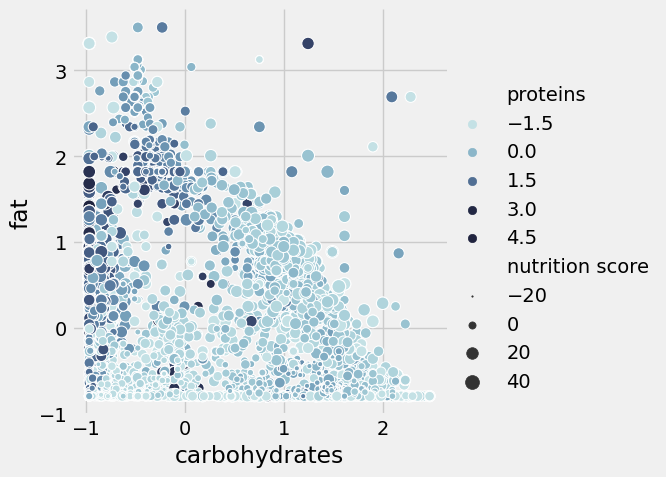

In [103]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(data=plot_df,x="carbohydrates", y="fat", hue="proteins", 
            size='nutrition score', palette=cmap, sizes=(1, 100))

In [106]:
plot_df['new score'] = list(map(lambda x : "unhealthy" if x > 6 else 'healthy', plot_df['nutrition score']))

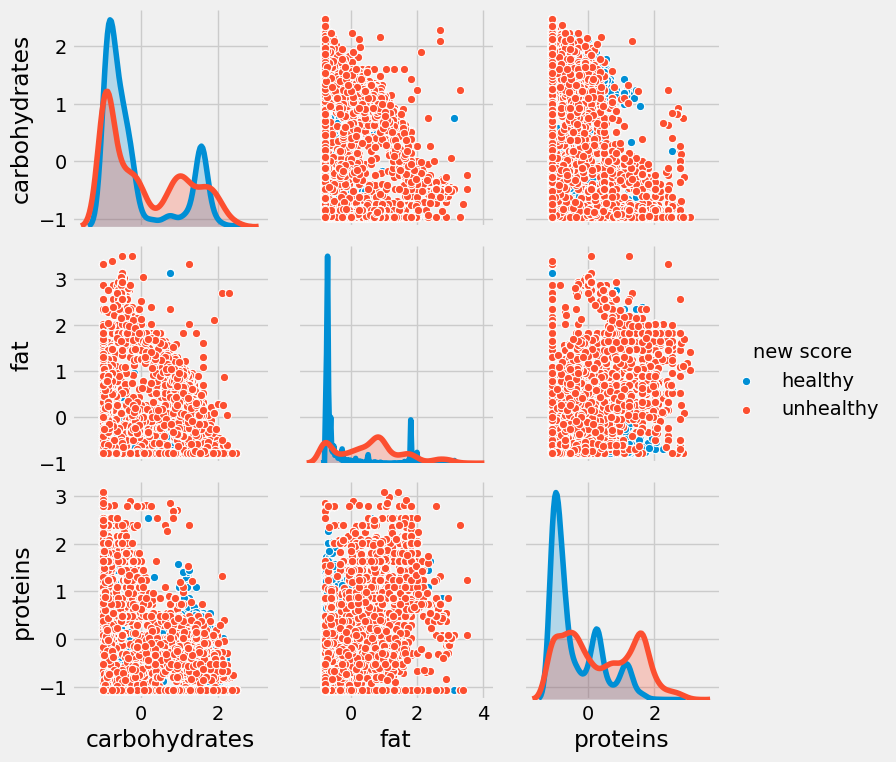

In [107]:
sns.pairplot(plot_df[['carbohydrates', 'fat', 'proteins', 'new score']], hue = 'new score')

In [19]:
# clean_df.to_csv('/Users/gabrieltaylor/Python/STAT542/STAT542/gabet/clean_df.csv')

## How many ingredients are we leaving out by only keeping the top 1000?

In [20]:
most_common_words_df = pd.DataFrame(most_common_words, index = [1])

In [21]:
most_common_words_df = most_common_words_df.transpose().reset_index()

In [22]:
most_common_words_df.columns = ['ingredient', 'freq']

In [23]:
sum(most_common_words_df['freq'] / len(all_words))

0.6305187681525436

#### We're still keeping 63% of the ingredients when only keeping the top 1000

In [24]:
most_common_words_df['dist'] = most_common_words_df['freq'] / len(all_words)

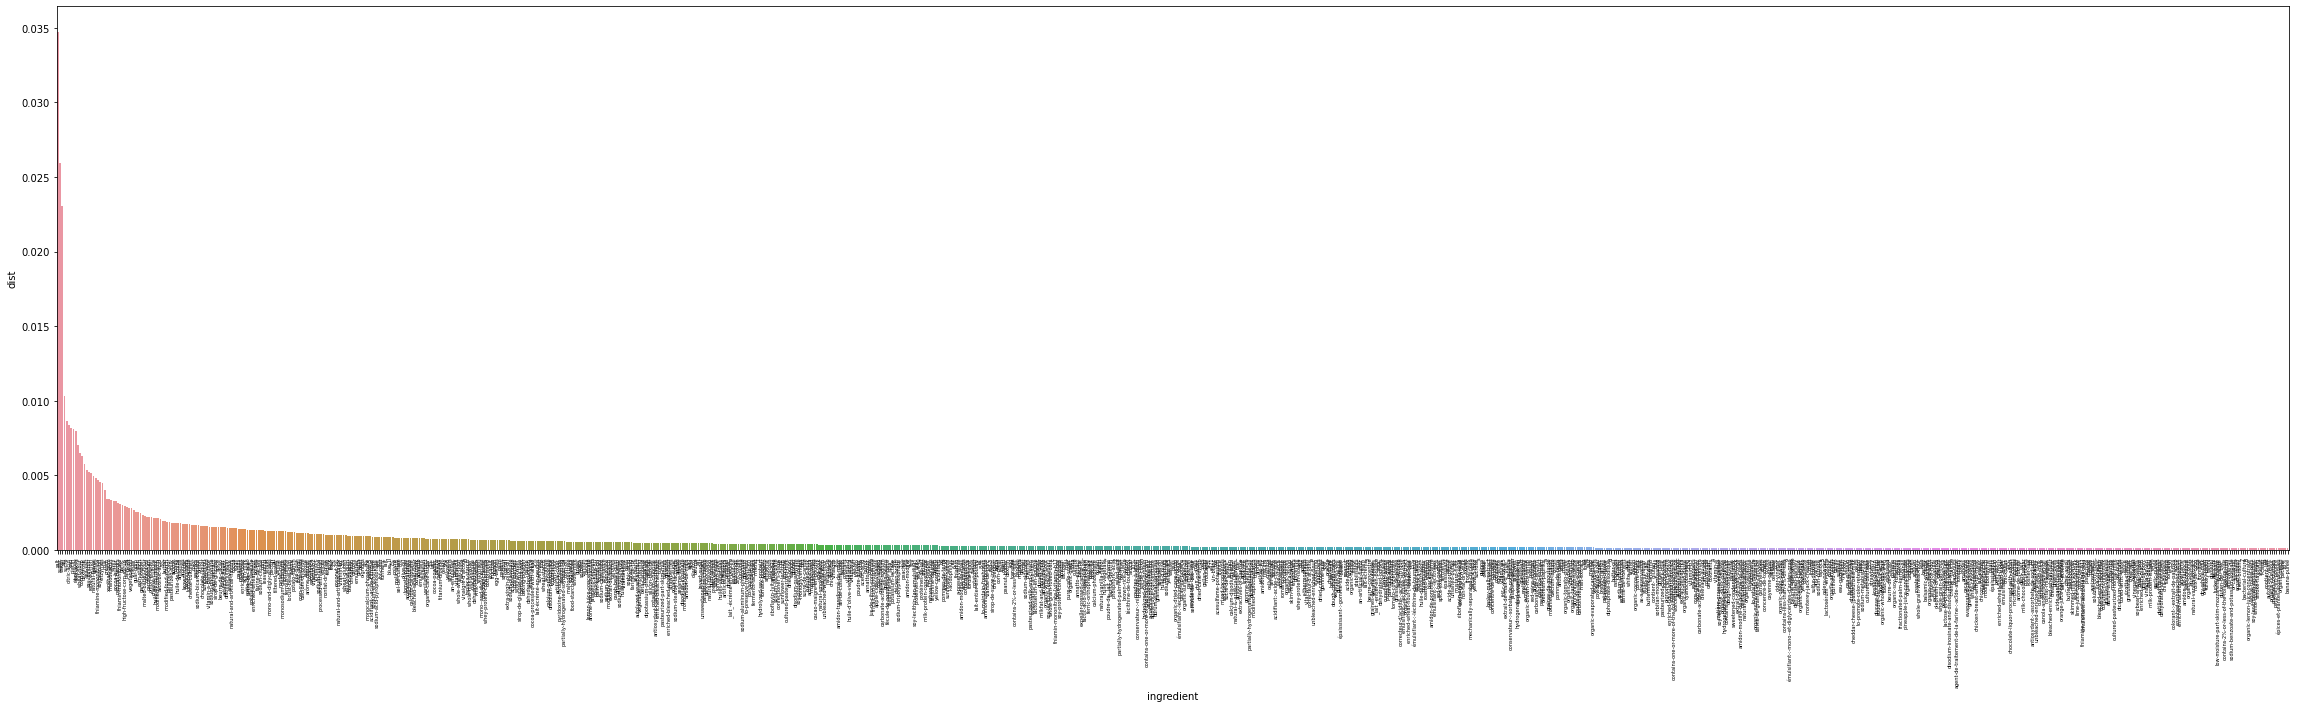

In [25]:
plt.figure(figsize=(40, 10))
sns.barplot(x = "ingredient", y = "dist", data = most_common_words_df)
plt.xticks(fontsize = 5, rotation = 90)
plt.show()

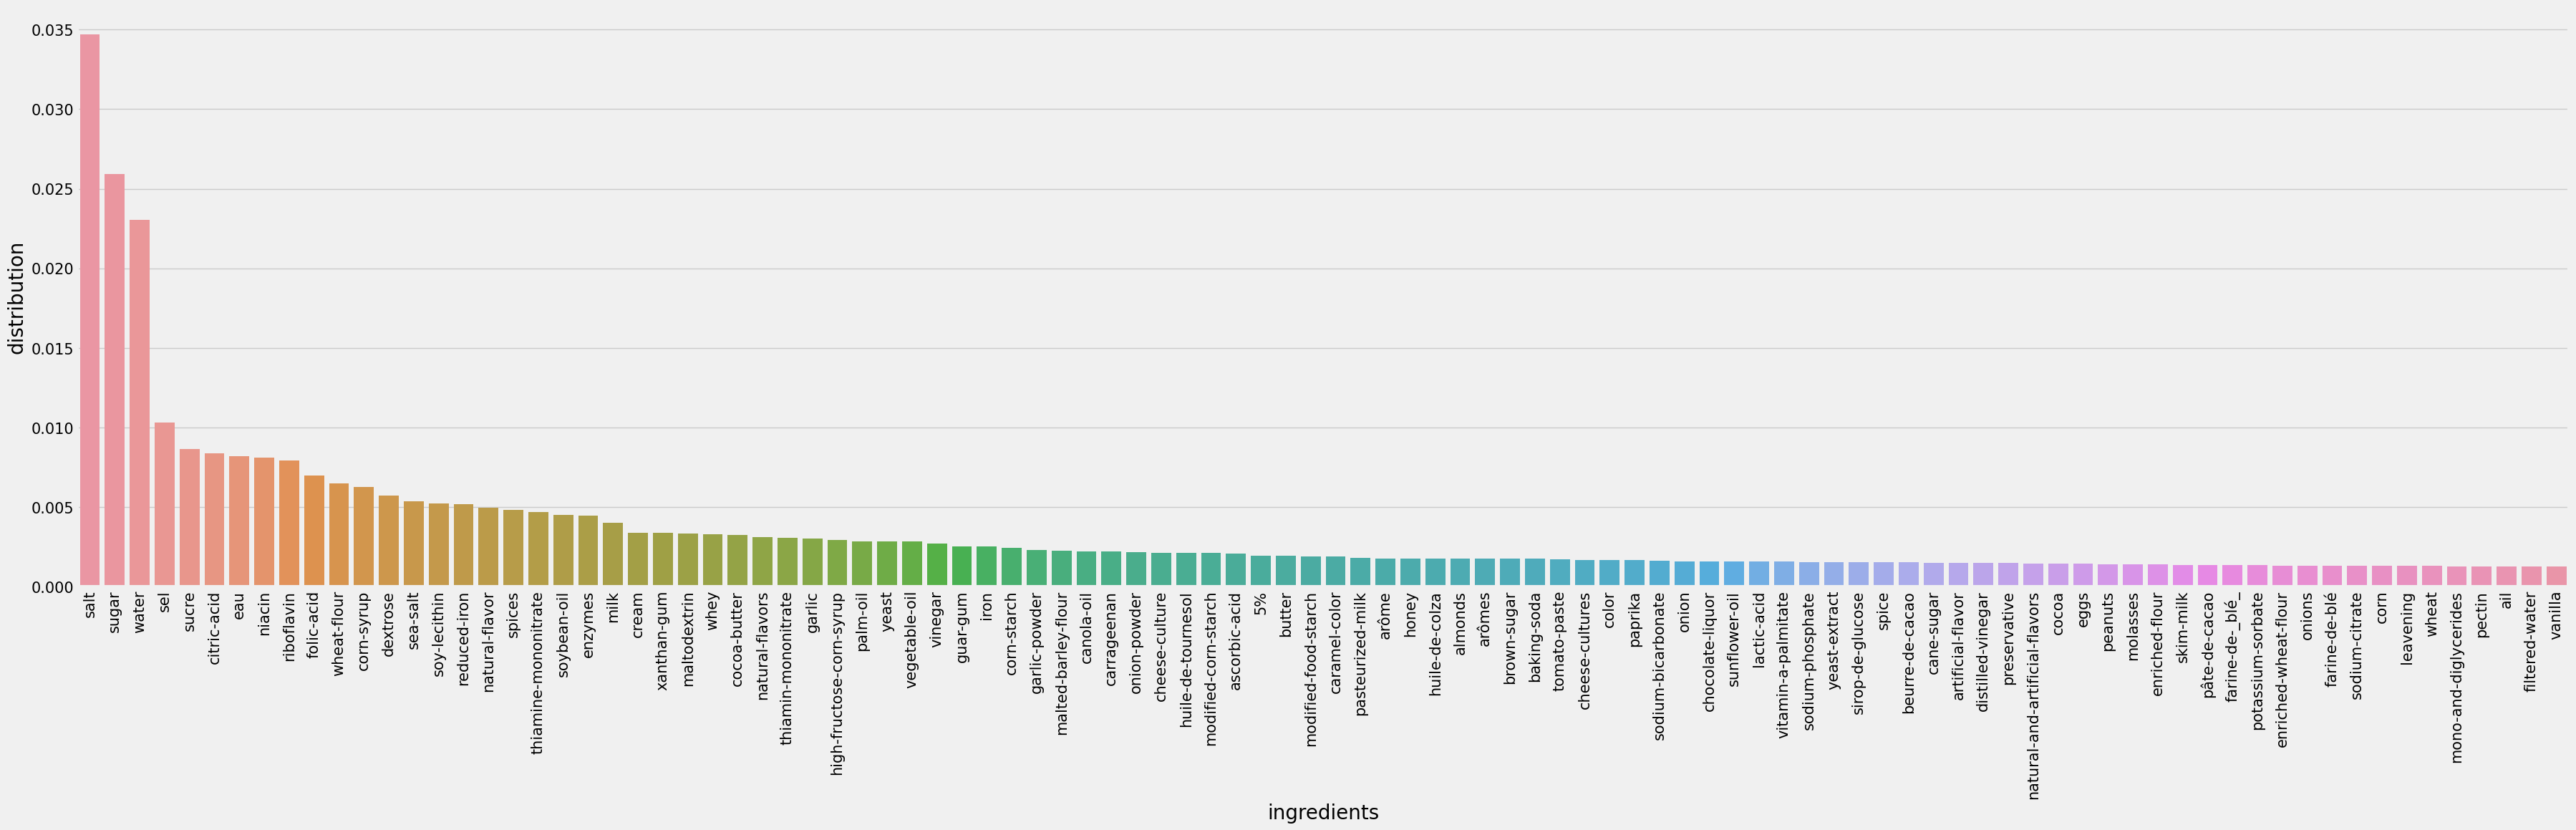

In [93]:
plt.figure(figsize=(40, 10))
sns.barplot(x = "ingredient", y = "dist", data = most_common_words_df.iloc[:100, :])
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)
plt.xlabel('ingredients', fontsize = 20)
plt.ylabel('distribution', fontsize = 20)
plt.show()